# Food Inflation Across Major Economic Periods

*In this notebook, we examine how food inflation has evolved across major U.S. economic periods, including the 1970s inflation era, the 2008 recession, the COVID-19 shock, and the 2021–2023 inflation spike. We focus on descriptive time-series methods, including rolling statistics and change-point detection, to identify shifts in inflation behavior.*

*We are trying to answer the question of how does food inflation evolve over time, and do different food categories exhibit distinct inflation regimes, volatility, and persistence across major economic periods?*

We begin by importing the core Python libraries used throughout this analysis. A fixed random seed is set to ensure reproducibility for any stochastic procedures used later in the notebook.


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

np.random.seed(159)
plt.rcParams["figure.figsize"] = (14, 6)

The CPI dataset captures changes in retail food prices paid by consumers, while the PPI dataset reflects price changes received by producers at the farm or wholesale level. Both datasets are indexed by year and report annual percentage changes, which makes them suitable for time-series analysis focused on long-run inflation dynamics rather than short-term seasonal fluctuations.

In [2]:
cpi = pd.read_csv("../data/processed/processed_cpi.csv")
ppi = pd.read_csv("../data/processed/processed_ppi.csv")

# Overall Food Inflation Dynamics

Because we have access to overall food groups and food by category, we can see the differences not only within periods but also between each category. First, we will start with overall food inflation.

## Aggregate Food Inflation Time Series

*Before disaggregating by category, we first examine how overall food inflation has evolved over time. This plot provides a baseline view of food inflation, highlighting pronounced spikes during the 1970s and the post-COVID period, with relatively stable inflation in the intervening decades.*

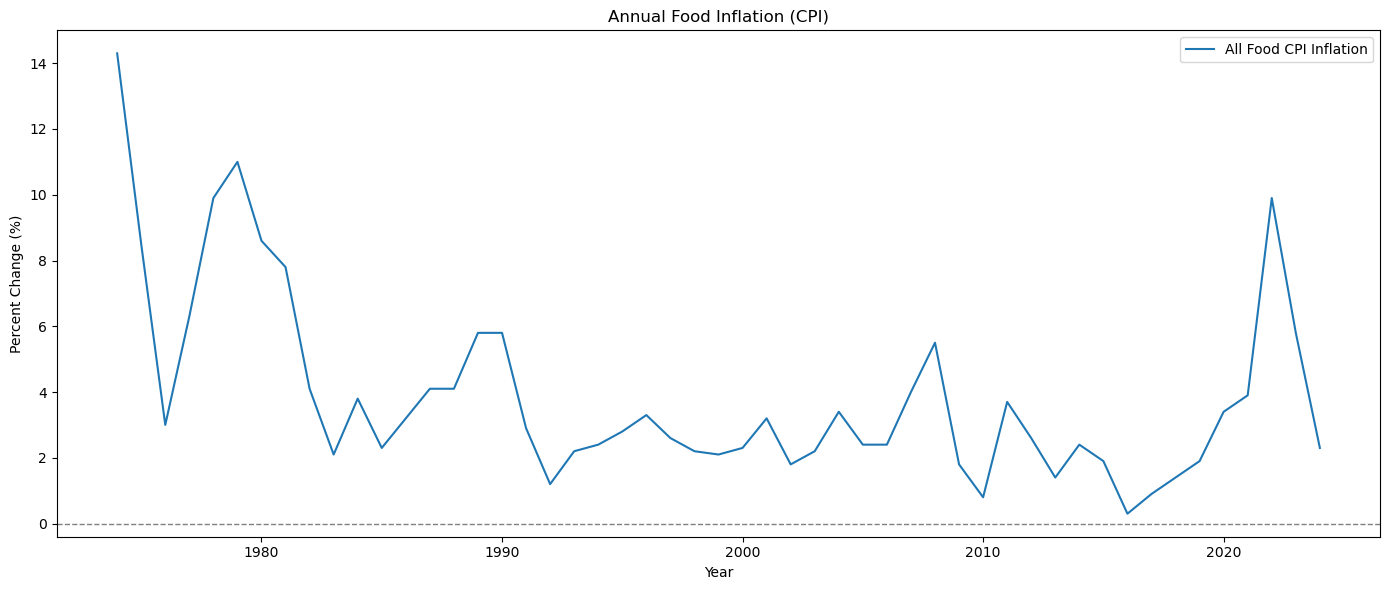

In [3]:
plt.figure()
plt.plot(cpi["Year"], cpi["All_food"], label="All Food CPI Inflation")

# To draw a horizontal reference line as a baseline
plt.axhline(0, color="gray", linewidth=1, linestyle="--") 

plt.title("Annual Food Inflation (CPI)")
plt.xlabel("Year")
plt.ylabel("Percent Change (%)")
plt.legend()

plt.tight_layout()
plt.savefig("../figures/annual_cpi_food_inflation.png")
plt.show()

# Broken Stick Regression 

*To examine whether the long-run behavior of food inflation has changed over time, we estimate a broken-stick (change-of-slope) regression for aggregate food inflation. Unlike change-point methods (we will see model it later) that search for abrupt shifts in levels or volatility, this approach allows the trend of inflation to evolve gradually, capturing changes in the direction or persistence of inflation rather than sudden breaks.*

Food inflation is shaped by slow-moving forces like monetary regimes, globalization, and structural changes in food supply chains—making sharp breaks unlikely. The broken-stick model is therefore well-suited to detect trend regime changes that occur smoothly over time. This complements our earlier finding that formal change-point detection does not identify statistically sharp breaks in aggregate food inflation.

The estimated breakpoint corresponds to the year in which the slope of the inflation trend changes, not a sudden inflation shock. In this context, the breakpoint should be interpreted as the onset of a new long-run inflation regime, reflecting changes in underlying economic conditions rather than discrete events.

In [4]:
years = cpi["Year"].to_numpy()
y = cpi["All_food"].to_numpy()

In [5]:
def relu(t, c):
    return np.maximum(0, t - c)

In [6]:
def rss_single_break(y, n, t, c):
    X = np.column_stack([
        np.ones(n),
        t,
        relu(t, c)
    ])

    model = sm.OLS(y, X).fit()
    return np.sum(model.resid ** 2)

In [7]:
n = len(y)
t = np.arange(n)

candidate_cs = np.arange(3, n - 3)
rss_vals = np.array([rss_single_break(y, n, t, c) for c in candidate_cs])

c_hat = candidate_cs[np.argmin(rss_vals)]
break_year = years[c_hat]
break_year

np.int64(1985)

In [8]:
X_broken = np.column_stack([
    np.ones(n),
    t,
    relu(t, c_hat)
])

broken_model = sm.OLS(y, X_broken).fit()
broken_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     23.15
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           9.16e-08
Time:                        05:14:18   Log-Likelihood:                -108.71
No. Observations:                  51   AIC:                             223.4
Df Residuals:                      48   BIC:                             229.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6287      1.059     10.035      0.000       8.499      12.758
x1            -0.6909      0.121     -5.714      0.000      -0.934      -0.448
x2             0.6882      0.137      5.025      0.000       0.413       0.964
==============================================================================
Omnibus:                        9.585   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               14.385
Skew:                           0.524   Prob(JB):                     0.000752
Kurtosis:                       5.382   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
X_linear = np.column_stack([
    np.ones(n),
    t
])

linear_model = sm.OLS(y, X_linear).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     14.08
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           0.000465
Time:                        05:14:18   Log-Likelihood:                -119.48
No. Observations:                  51   AIC:                             243.0
Df Residuals:                      49   BIC:                             246.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1756      0.709      8.707      0.000       4.750       7.601
x1            -0.0917      0.024     -3.752      0.000      -0.141      -0.043
==============================================================================
Omnibus:                       21.654   Durbin-Watson:                   0.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.194
Skew:                           1.507   Prob(JB):                     2.78e-07
Kurtosis:                       5.264   Cond. No.                         57.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

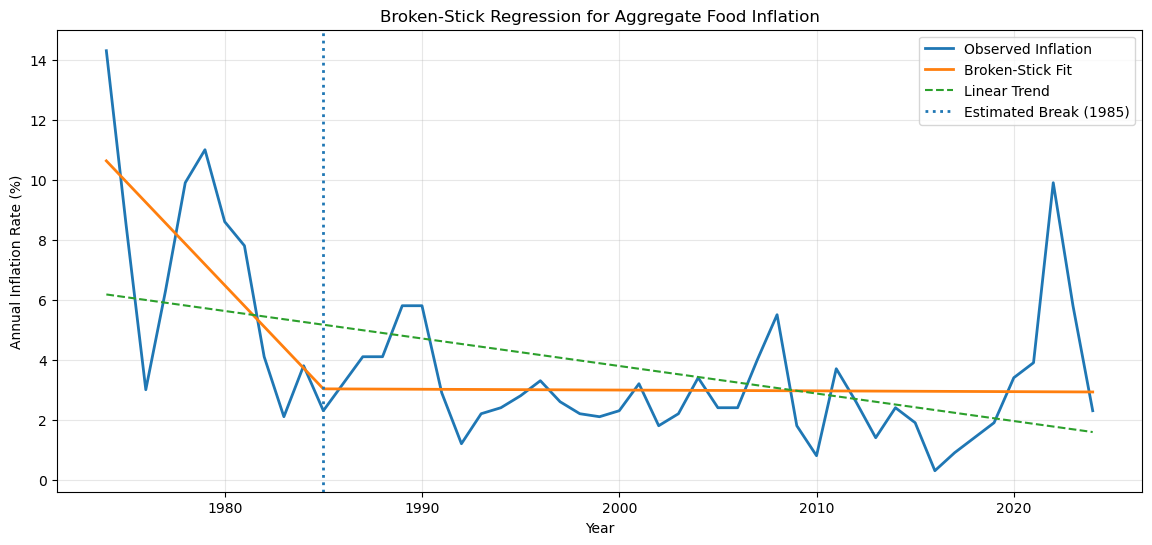

In [10]:
plt.figure()

plt.plot(years, y, label="Observed Inflation", linewidth=2)
plt.plot(years, broken_model.fittedvalues, label="Broken-Stick Fit", linewidth=2)
plt.plot(years, linear_model.fittedvalues, linestyle="--", label="Linear Trend")

plt.axvline(break_year, linestyle=":", linewidth=2,
            label=f"Estimated Break ({break_year})")

plt.title("Broken-Stick Regression for Aggregate Food Inflation")
plt.xlabel("Year")
plt.ylabel("Annual Inflation Rate (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../figures/broken_stick_regression_for_agg_food_inflation.png")
plt.show()

## Inflation Regimes Across Economics Periods  

*Food inflation exhibits distinct patterns across historical eras shaped by major macroeconomic events. We define inflation regimes as periods in which inflation displays relatively similar behavior in terms of level and variability. By grouping years into economically meaningful periods, we create a structured framework for comparing how food inflation differs across eras.*

In [11]:
def assign_period(year):
    if 1974 <= year <= 1981:
        return "1970s Inflation"
    elif 2008 <= year <= 2009:
        return "Great Recession"
    elif 2020 <= year <= 2021:
        return "COVID-19"
    elif 2022 <= year <= 2023:
        return "Post-COVID Inflation"
    else:
        return "Baseline Period"

cpi["Period"] = cpi["Year"].apply(assign_period)

**Period Summary Table**

Having defined economically meaningful periods, we summarize how food inflation behaves within each regime. Reporting the mean, standard deviation, and range of inflation rates allows us to compare both average inflation levels and volatility across historical contexts, providing a baseline for the visual and time-series analyses that follow.

In [12]:
period_summary = (
    cpi.groupby("Period")["All_food"]
    .agg(["mean", "std", "min", "max"])
    .round(2)
)

period_summary

,mean,std,min,max
Period,,,,
1970s Inflation,8.68,3.32,3.0,14.3
Baseline Period,2.66,1.21,0.3,5.8
COVID-19,3.65,0.35,3.4,3.9
Great Recession,3.65,2.62,1.8,5.5
Post-COVID Inflation,7.85,2.90,5.8,9.9


**Distributional Comparison Across Regimes**

This figure complements the Period Summary Table by showing the full distribution of inflation within each regime, not just summary statistics.

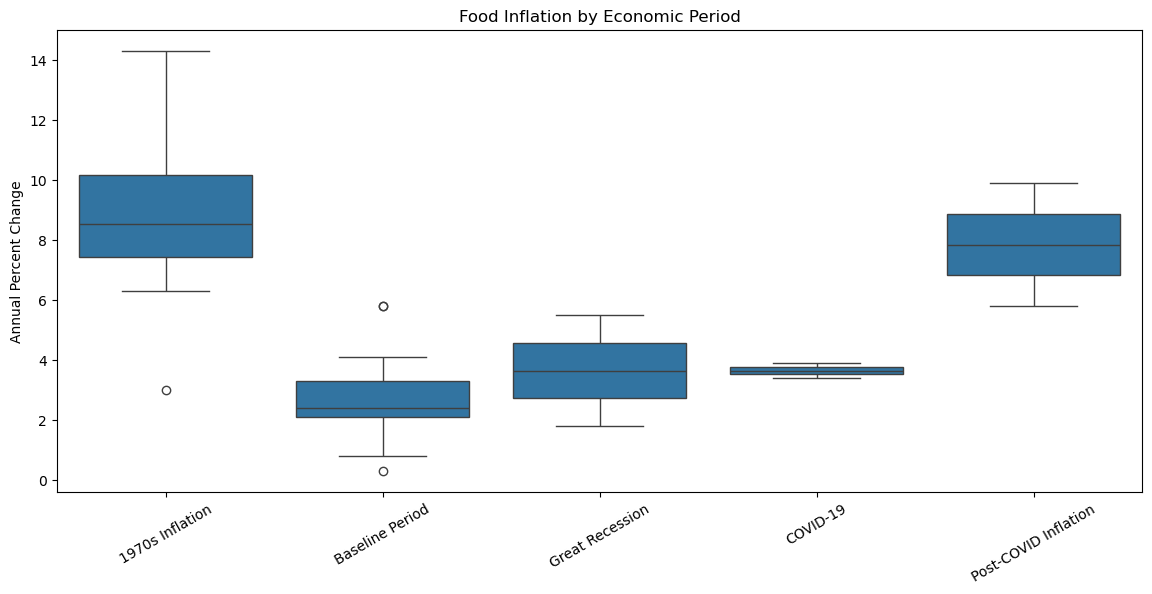

In [13]:
plt.figure()
sns.boxplot(data=cpi, x="Period", y="All_food")
plt.xticks(rotation=30)
plt.title("Food Inflation by Economic Period")
plt.ylabel("Annual Percent Change")
plt.xlabel("")
plt.savefig("../figures/food_inflation_by_econ_period_boxplot.png")
plt.show()

## Volatillity and Distribution Across Regimes

*Now that we see that food inflation differs substantially across economic periods, both in level and variability. In particular, periods such as the late 1970s and the post-COVID years exhibit unusually high inflation and greater volatility. In this section, we examine how food inflation evolves over time in more detail and explore potential sources of these changes by analyzing inflation volatility and comparing consumer- and producer-level price dynamics.*

**Rolling Volatility (5-year Window)**

Visual evidence suggests that spikes in food inflation are not evenly distributed over time but instead cluster around major economic disruptions. To better understand these patterns, we first analyze how the volatility of food inflation changes over time using rolling statistics. We then compare consumer food prices (CPI) with producer and wholesale food prices (PPI) to explore whether periods of elevated consumer inflation coincide with upstream price pressures.

*Rolling statistics help reveal how the behavior of a time series changes over time, rather than assuming it is constant across the entire period.*

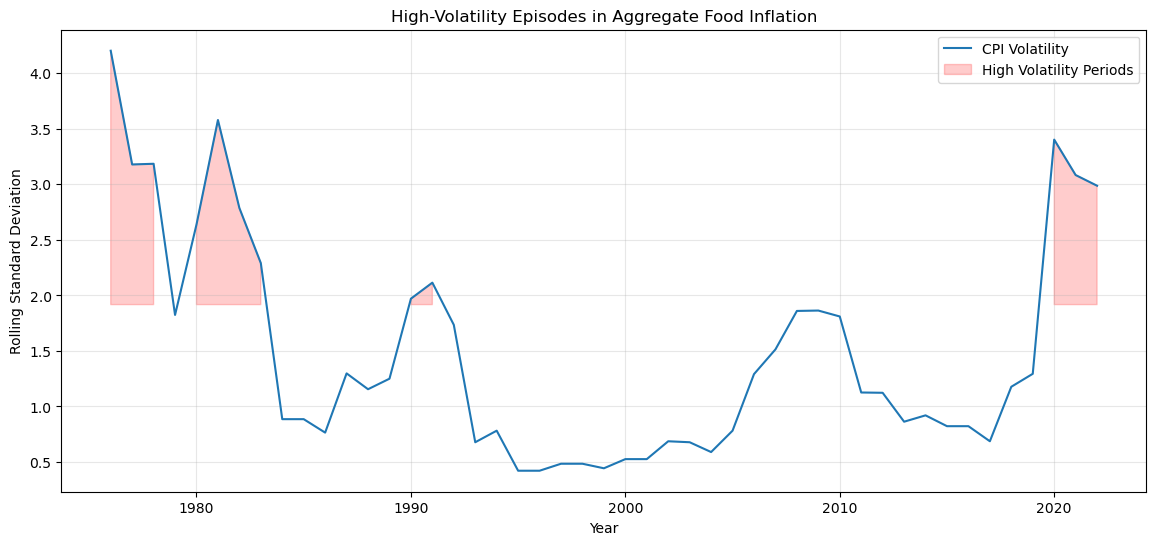

In [14]:
# Compute rolling volatility (5-year rolling standard deviation)
window = 5

cpi["All_food_rolling_std"] = (
    cpi["All_food"]
    .rolling(window=window, center=True)
    .std()
)

# Plot rolling volatility
threshold = cpi["All_food_rolling_std"].quantile(0.75)

plt.figure()
plt.plot(cpi["Year"], cpi["All_food_rolling_std"], label="CPI Volatility")

plt.fill_between(
    cpi["Year"],
    cpi["All_food_rolling_std"],
    threshold,
    where=cpi["All_food_rolling_std"] >= threshold,
    color="red",
    alpha=0.2,
    label="High Volatility Periods"
)

plt.title("High-Volatility Episodes in Aggregate Food Inflation")
plt.xlabel("Year")
plt.ylabel("Rolling Standard Deviation")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../figures/high_volatility_episodes_in_agg_food_inflation.png")
plt.show()

**CPI and PPI Rolling Voltaility**

We can also compared the five-year rolling volatility in aggregate food prices measured at both the consumer level and the producer level. Shaded regions indicate periods of joint high volatility, where both series experience elevated fluctuations simultaneously. Building on the category-level volatility analysis, this comparison assesses whether volatility observed by consumers is closely linked to upstream cost volatility faced by producers. The strong correlation between CPI and PPI volatility suggests that aggregate food price instability is largely driven by common supply-side shocks rather than category-specific consumer dynamics.

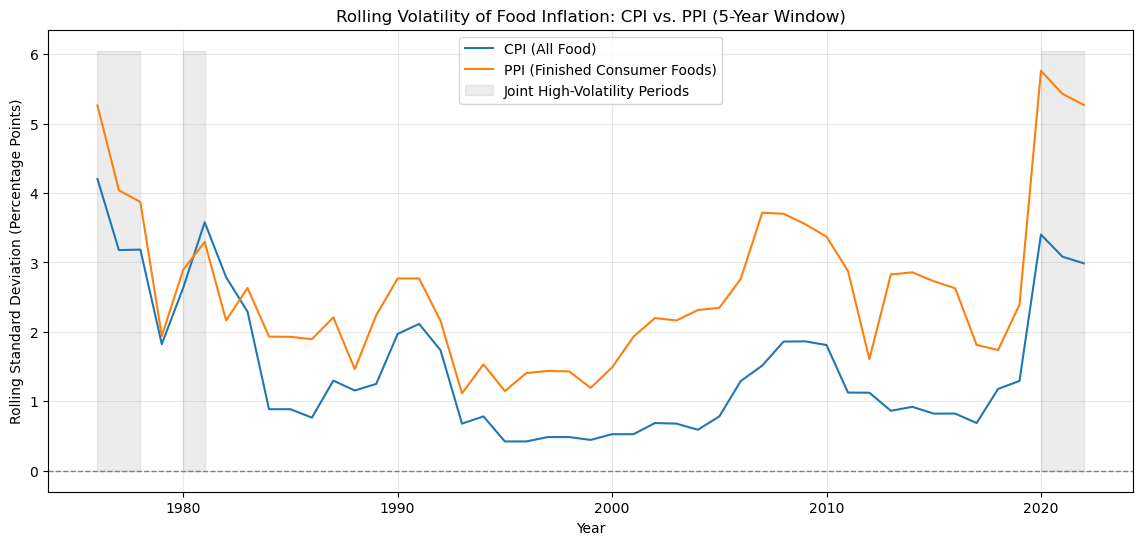

In [15]:
# Rolling volatility for PPI (All Food)
ppi["All_food_rolling_std"] = (
    ppi["Finished_consumer_foods"]
    .rolling(window=5, center=True)
    .std()
)

# Plot CPI vs PPI volatility
plt.figure()
plt.plot(cpi["Year"], cpi["All_food_rolling_std"], label="CPI (All Food)")
plt.plot(ppi["Year"], ppi["All_food_rolling_std"], label="PPI (Finished Consumer Foods)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Rolling Volatility of Food Inflation: CPI vs. PPI (5-Year Window)")
plt.xlabel("Year")
plt.ylabel("Rolling Standard Deviation (Percentage Points)")

threshold_cpi = cpi["All_food_rolling_std"].quantile(0.75)
threshold_ppi = ppi["All_food_rolling_std"].quantile(0.75)

# Joint high-volatility condition
shared_high_vol = (
    (cpi["All_food_rolling_std"] >= threshold_cpi) &
    (ppi["All_food_rolling_std"] >= threshold_ppi)
)

# Adding shading to highlight joint high-volatility periods
plt.fill_between(
    cpi["Year"],
    0,
    plt.ylim()[1],
    where=shared_high_vol,
    color="gray",
    alpha=0.15,
    label="Joint High-Volatility Periods"
)

plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../figures/5y_rolling_volatility_food_inflation_cpi_vs_ppi.png")
plt.show()

**Correlation Between CPI and PPI Volatility**

This aggregate comparison reveals much stronger co-movement between CPI and PPI volatility. At the economy-wide level, food price instability tends to rise and fall together across the production and consumption stages. You can use the traditional values of -1 to +1 to determine what is a strong relationship or not.

In [16]:
vol_df = pd.DataFrame({
    "CPI_volatility": cpi["All_food_rolling_std"],
    "PPI_volatility": ppi["All_food_rolling_std"]
}).dropna()

volatility_corr = vol_df.corr().iloc[0, 1]
volatility_corr

np.float64(0.806999230588202)

## Persistence
*Persistence asks the question of if shocks last, or do prices revert quickly? In this case, when inflation in a category spikes, does it tend to stay high the next year, or does it quickly fall back?*
* High autocorrelation → persistent inflation
* Low or near-zero → mean-reverting / transitory shocks

This table reports lag-1 autocorrelations for CPI and PPI food inflation to assess persistence. CPI inflation exhibits higher persistence than PPI, suggesting that consumer food price shocks tend to carry over more strongly across years than producer-level shocks.

In [17]:
cpi_persistence = cpi["All_food"].autocorr(lag=1)
ppi_persistence = ppi["Finished_consumer_foods"].autocorr(lag=1)

pd.Series({
    "CPI (All Food)": cpi_persistence,
    "PPI (Finished Consumer Foods)": ppi_persistence
})

CPI (All Food)                   0.672293
PPI (Finished Consumer Foods)    0.313566
dtype: float64

## CPI VS PPI for Overall Food Groups

*To examine whether consumer food inflation reflects upstream price pressures, we compare food inflation measured at the consumer level (CPI) with producer- and wholesale-level prices (PPI). While CPI captures prices paid by consumers, PPI reflects earlier movements in the supply chain. Comparing these series helps assess whether spikes in consumer food inflation coincide with changes in producer prices.*

**CPI vs PPI Producer Food Inflation**

We can  compares CPI and PPI food inflation over time to examine whether consumer price increases coincide with upstream producer price movements, shedding light on the sources and transmission of food inflation.

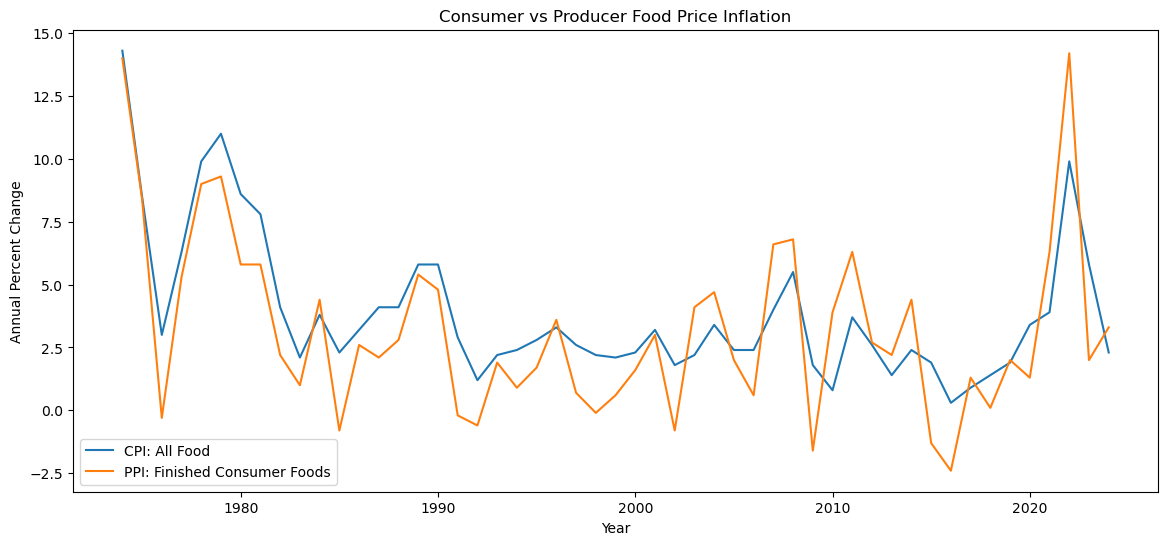

In [18]:
# Plot CPI vs PPI over time
plt.figure()

plt.plot(
    cpi["Year"],
    cpi["All_food"],
    label="CPI: All Food",
)

plt.plot(
    ppi["Year"],
    ppi["Finished_consumer_foods"],
    label="PPI: Finished Consumer Foods",
)

plt.title("Consumer vs Producer Food Price Inflation")
plt.xlabel("Year")
plt.ylabel("Annual Percent Change")
plt.legend()
plt.savefig("../figures/cpi_all_food_vs_ppi_finished_consumer_foods.png")
plt.show()

## Change Point Detection

*Change-point detection is used to test whether food inflation exhibits sharp structural breaks—years in which the behavior of inflation changes abruptly rather than gradually. Using a conservative specification, no statistically meaningful change points are detected, indicating that food inflation changes gradually over time rather than through sharp regime shifts. We can also relate the year to the earlier Broken Stick Regression model and see if there are any overlaps in the years.*

* Lower Penalty (pen = 3) → More sensitive + flag small changes = risk of overfitting
* Higher Penalty (pen = 5) → More conservative + detects large, persistents shifts = lower risk of false postitives
  
At a conservative penalty level, no statistically meaningful change points are detected in aggregate food inflation, suggesting that while inflation fluctuates, it does not exhibit sharp structural breaks when viewed at the annual level.

In [19]:
series = cpi["All_food"].values

# Fit change-point model (detect mean shifts)
model = rpt.Pelt(model="rbf").fit(series)

# Detect breakpoints
breaks = model.predict(pen=5)

# Convert to years
change_years = cpi.iloc[np.array(breaks[:-1])]["Year"].values
change_years

array([], dtype=int64)

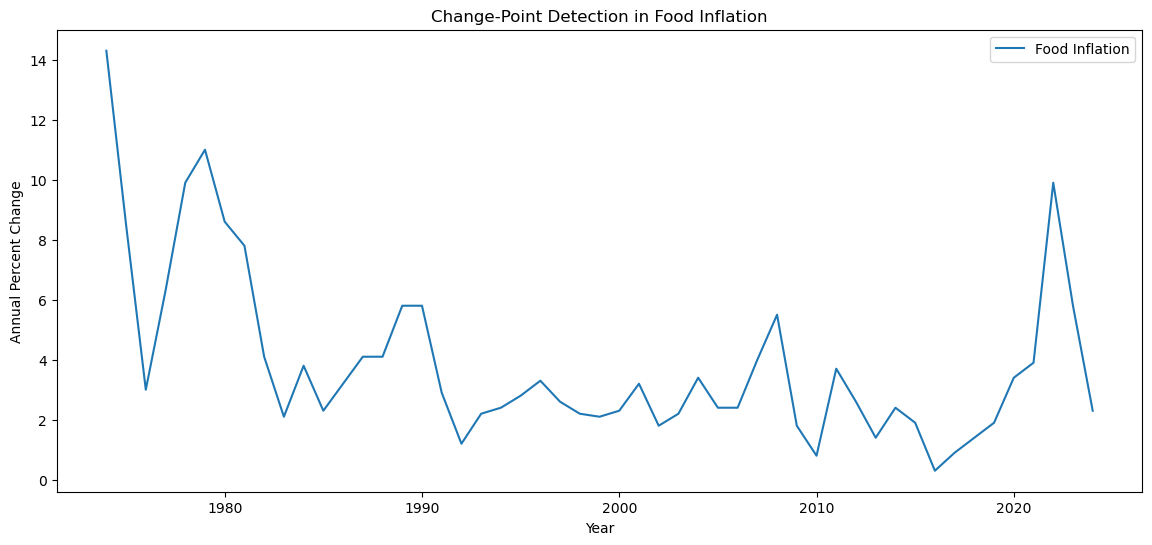

In [20]:
plt.figure()
plt.plot(cpi["Year"], cpi["All_food"], label="Food Inflation")

for yr in change_years:
    plt.axvline(yr, linestyle="--", alpha=0.6)

plt.title("Change-Point Detection in Food Inflation")
plt.xlabel("Year")
plt.ylabel("Annual Percent Change")
plt.legend()
plt.savefig("../figures/change_point_detection_in_food_inflation.png")
plt.show()

In [21]:
# Above we fit with a higher penalty but what if try fitting with a lower penalty?
series = cpi["All_food"].values

# Fit change-point model (detect mean shifts)
model = rpt.Pelt(model="rbf").fit(series)

# Detect breakpoints
breaks = model.predict(pen=3) #I lowered the penalty from 5 to 3 now, let's see if there is a change...

# Convert to years
change_years = cpi.iloc[np.array(breaks[:-1])]["Year"].values
change_years
# As you can see, the array below marks the year 1984, where at penalty = 3, there is detected some changes

array([1984])

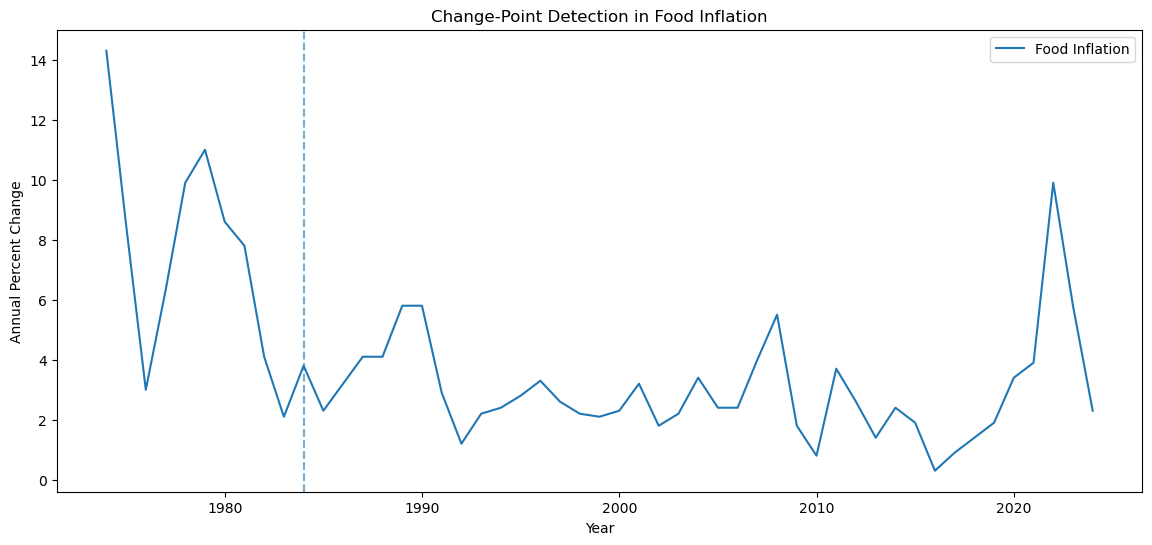

In [22]:
plt.figure()
plt.plot(cpi["Year"], cpi["All_food"], label="Food Inflation")

for yr in change_years:
    plt.axvline(yr, linestyle="--", alpha=0.6)

plt.title("Change-Point Detection in Food Inflation")
plt.xlabel("Year")
plt.ylabel("Annual Percent Change")
plt.legend()
plt.savefig("../figures/change_point_detection_in_food_inflation_lower_penalty.png")
plt.show()

# Category-Level Food Inflation Dynamics 

*Aggregate food inflation may conceal meaningful differences across food types. To uncover these patterns, we analyze inflation dynamics separately for the largest food categories—fruits and vegetables, dairy, meats, cereals and bakery products, and fats and oils. Focusing on these major categories allows us to examine heterogeneity in volatility, persistence, and correlation that is not visible in the aggregate index.*

We first sort the data chronologically and set year as the time index to facilitate time-series analysis. We then define a set of major food categories that will be analyzed individually in the sections that follow.

In [23]:
cpi = cpi.sort_values("Year")
cpi_ts = cpi.set_index("Year")

In [24]:
food_categories = [
    "Fruits_and_vegetables",
    "Dairy_products",
    "Meats",
    "Cereals_and_bakery_products",
    "Fats_and_oils"
]

## Category Level Inflation Time Series

*Aggregate food inflation may conceal meaningful differences across categories. Different food groups face distinct cost structures and supply-side risks, which can lead to heterogeneous inflation dynamics over time. We therefore analyze major food categories separately to examine how inflation regimes, persistence, and volatility differ across food types.*

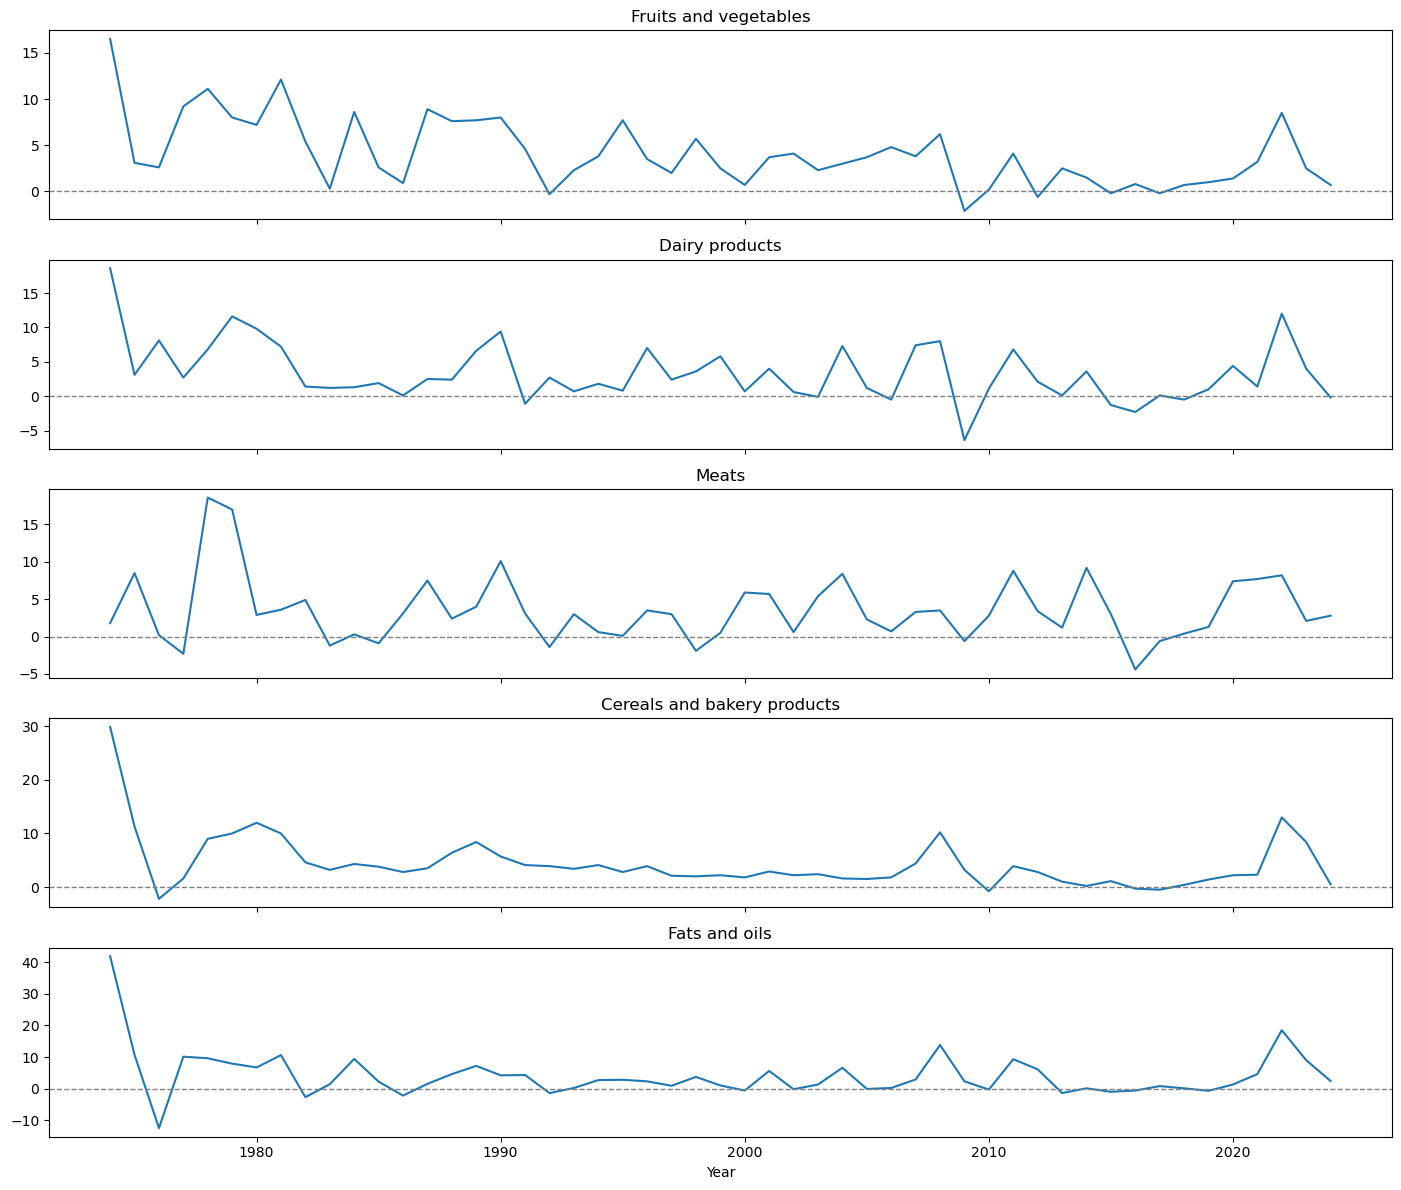

In [25]:
fig, axes = plt.subplots(len(food_categories), 1, figsize=(14, 12), sharex=True)

for ax, category in zip(axes, food_categories):
    ax.plot(cpi["Year"], cpi[category])
    ax.set_title(category.replace("_", " "))
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Year")
plt.tight_layout()
plt.savefig("../figures/inflation_by_categories.png")
plt.show()

## Broken-stick Regression by Category 

*We now can look at the broken-stick regression framework to individual food categories to assess whether long-run inflation trends differ across food types. Estimating a single slope change for each category allows us to compare how inflation dynamics evolve across sectors with distinct cost structures, supply chains, and exposure to shocks.*

Earlier analyses revealed substantial heterogeneity across food categories in terms of volatility, persistence, and volatility timing. Applying the broken-stick model at the category level allows us to determine whether this heterogeneity also appears in long-run inflation trends, rather than being driven solely by short-run fluctuations.

For each food category, the estimated breakpoint marks a year in which the trend growth rate of inflation changes, not a discrete price jump. Differences in breakpoint timing across categories indicate that food inflation regimes evolve asynchronously, reflecting category-specific dynamics such as input costs, perishability, regulation, and market structure.

In [26]:
def broken_stick_fit(y, years):
    n = len(y)
    t = np.arange(1, n + 1)

    def rss(c):
        X = np.column_stack([np.ones(n), t, relu(t, c)])
        return np.sum(sm.OLS(y, X).fit().resid ** 2)

    # search over admissible breakpoints
    cs = np.arange(3, n - 3)
    rss_vals = np.array([rss(c) for c in cs])
    c_hat = cs[np.argmin(rss_vals)]
    break_year = years[c_hat - 1]

    # final model
    X = np.column_stack([np.ones(n), t, relu(t, c_hat)])
    model = sm.OLS(y, X).fit()

    # linear comparison
    X_lin = np.column_stack([np.ones(n), t])
    lin_model = sm.OLS(y, X_lin).fit()

    return break_year, model, lin_model

In [27]:
results = {}

for cat in food_categories:
    y = cpi[cat].values
    break_year, model, lin_model = broken_stick_fit(y, years)

    results[cat] = {
        "break_year": break_year,
        "model": model,
        "linear": lin_model
    }

pd.Series({k: v["break_year"] for k, v in results.items()})

Fruits_and_vegetables          1976
Dairy_products                 1983
Meats                          1994
Cereals_and_bakery_products    1976
Fats_and_oils                  1976
dtype: int64

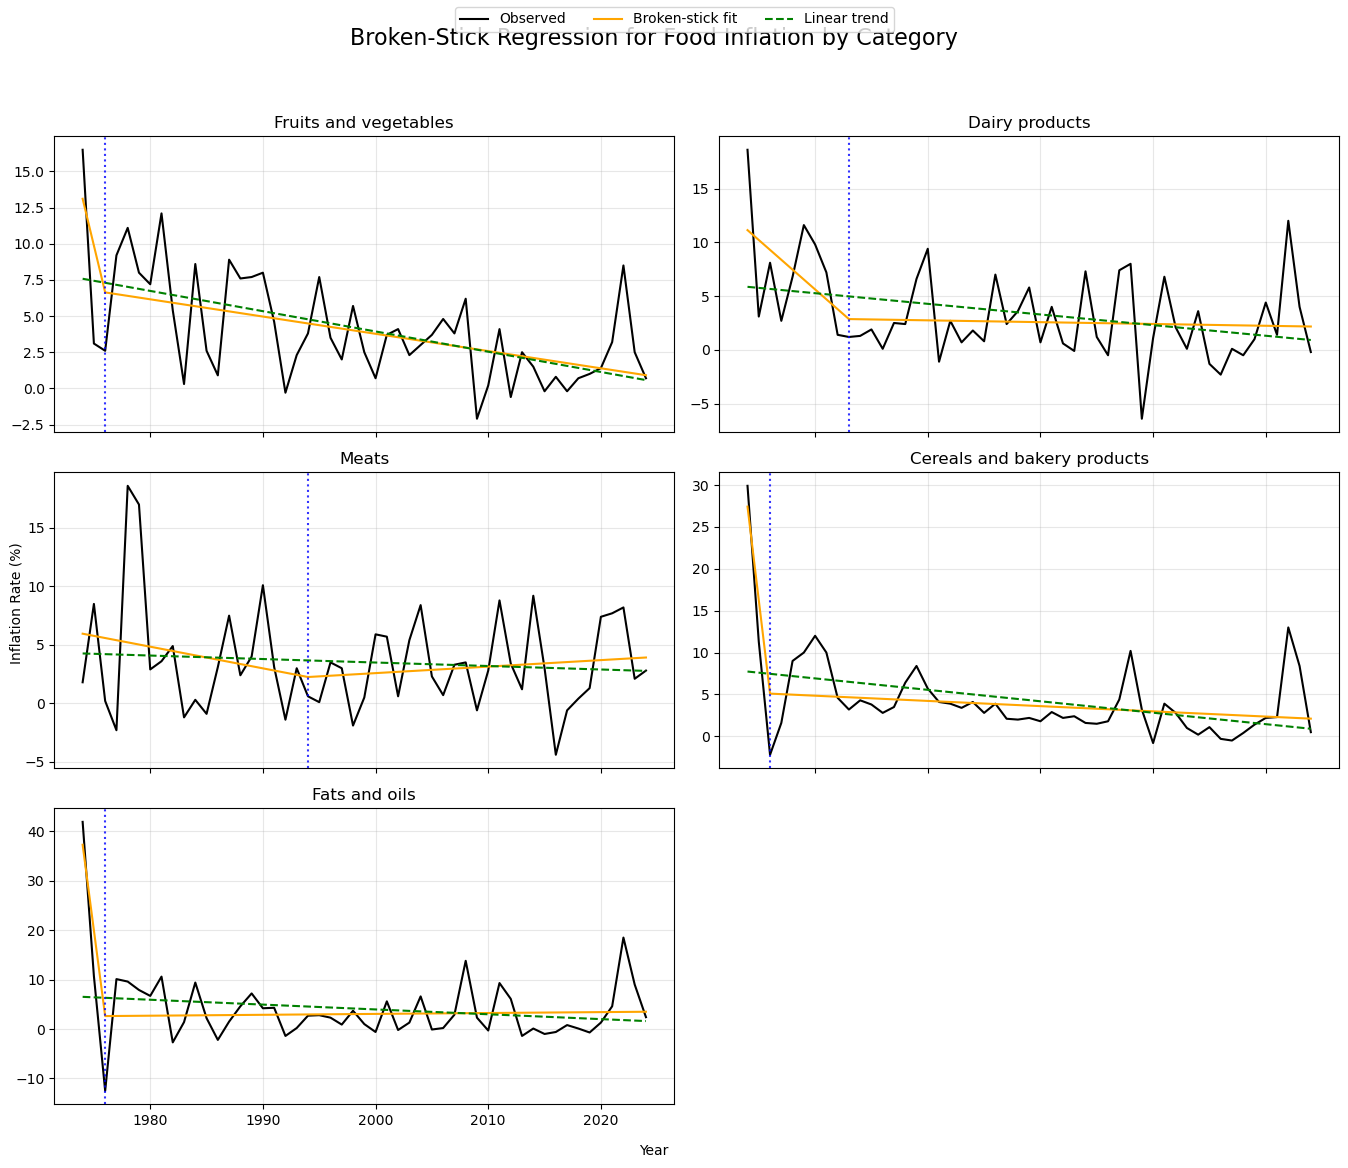

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()

for i, cat in enumerate(food_categories):
    ax = axes[i]
    y = cpi[cat].values

    ax.plot(years, y, color="black", label="Observed")
    ax.plot(years, results[cat]["model"].fittedvalues,
            color="orange", label="Broken-stick fit")
    ax.plot(years, results[cat]["linear"].fittedvalues,
            color="green", linestyle="--", label="Linear trend")

    ax.axvline(results[cat]["break_year"],
               color="blue", linestyle=":", alpha=0.8)

    ax.set_title(cat.replace("_", " "))
    ax.grid(alpha=0.3)

# Remove empty panel
axes[-1].axis("off")

# Global labels
fig.suptitle("Broken-Stick Regression for Food Inflation by Category", fontsize=16)
fig.text(0.5, 0.04, "Year", ha="center")
fig.text(0.04, 0.5, "Inflation Rate (%)", va="center", rotation="vertical")

# Legend only once
handles, labels=axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)

plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
plt.savefig("../figures/broken_stick_regression_food_inflation_by_category.png")
plt.show()

## Inflation Regimes Across Economic Periods by Category

*We group years into economically meaningful periods to compare food inflation across distinct historical regimes. By summarizing both average inflation and volatility within each period, this approach highlights differences in inflation levels and stability across major macroeconomic episodes.*

**Category-Level Food Inflation by Economics Period (Mean & Volatility)**

This table reports the mean and standard deviation of inflation rates for major food categories across economic periods, illustrating how inflation levels and volatility vary across categories and regimes.

In [29]:
category_period_summary = (
    cpi
    .groupby("Period")[food_categories]
    .agg(["mean", "std"])
)

category_period_summary

Fruits_and_vegetables           Dairy_products  \
                                      mean       std           mean   
Period                                                                
1970s Inflation                      8.725  4.624701       8.487500   
Baseline Period                      3.200  2.750152       2.205405   
COVID-19                             2.300  1.272792       2.900000   
Great Recession                      2.050  5.868986       0.800000   
Post-COVID Inflation                 5.500  4.242641       8.000000   

                                    Meats            \
                            std      mean       std   
Period                                                
1970s Inflation        5.082867  6.287500  7.754158   
Baseline Period        2.821637  2.727027  3.300896   
COVID-19               2.121320  7.550000  0.212132   
Great Recession       10.182338  1.450000  2.899138   
Post-COVID Inflation   5.656854  5.150000  4.313351   

                     Cereals_and_bakery_products           Fats_and_oils  \
                                            mean       std          mean   
Period                                                                     
1970s Inflation                        10.200000  9.424739     10.625000   
Baseline Period                         2.689189  1.942619      1.962162   
COVID-19                                2.250000  0.070711      2.950000   
Great Recession                         6.700000  4.949747      8.050000   
Post-COVID Inflation                   10.700000  3.252691     13.750000   

                                 
                            std  
Period                           
1970s Inflation       14.818208  
Baseline Period        3.044243  
COVID-19               2.333452  
Great Recession        8.131728  
Post-COVID Inflation   6.717514

**Category-Level Food Inflation Distributions Across Economic Periods**

Box plots show how inflation levels and volatility vary across economic periods within each major food category.

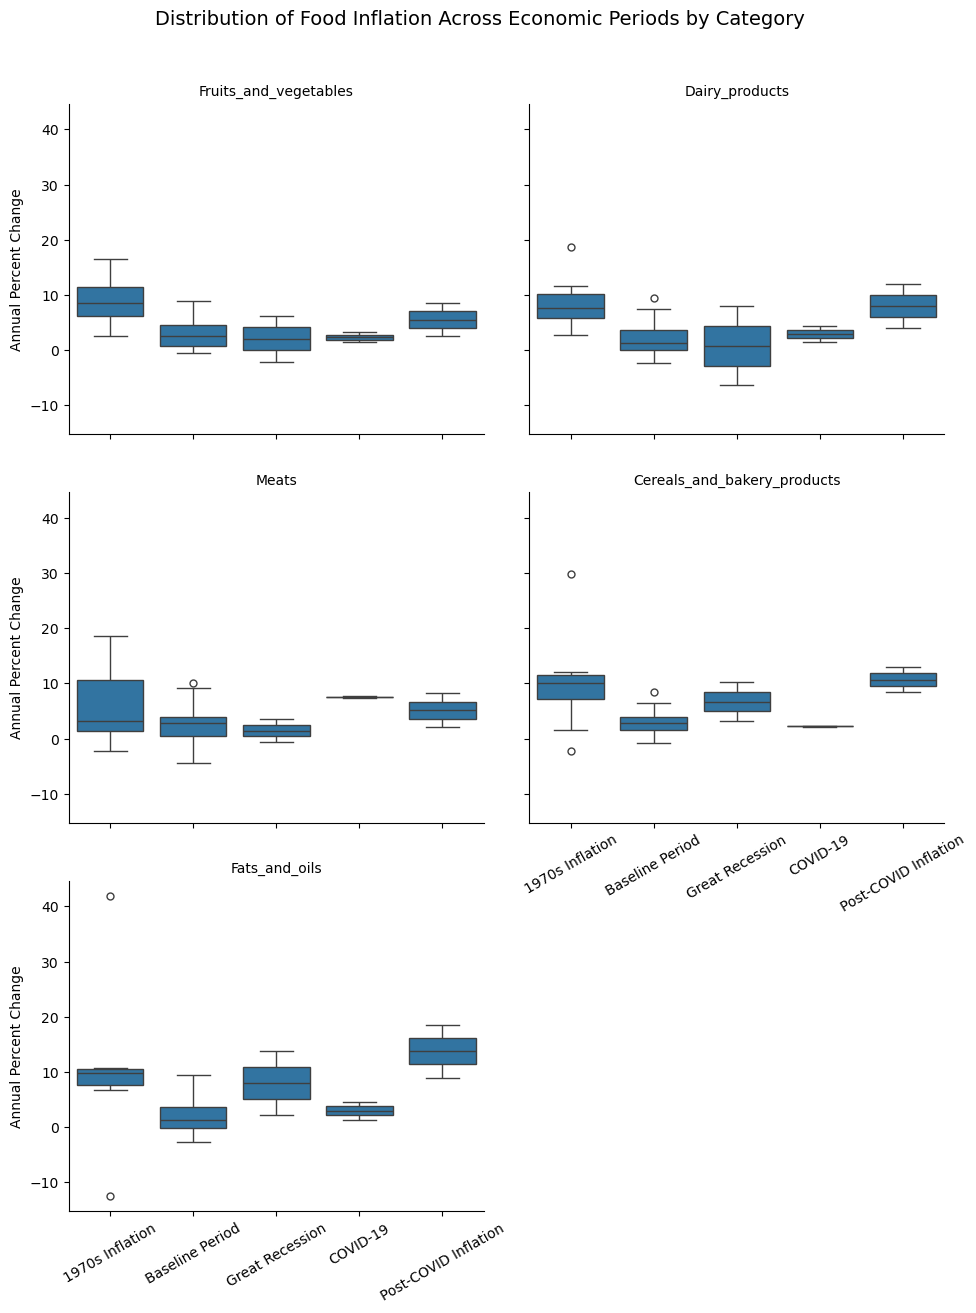

In [30]:
# Convert CPI data to long format for faceting
cpi_long = cpi.melt(
    id_vars=["Year", "Period"],
    value_vars=food_categories,
    var_name="Category",
    value_name="Inflation"
)

g = sns.catplot(
    data=cpi_long,
    x="Period",
    y="Inflation",
    col="Category",
    kind="box",
    col_wrap=2,
    height=4,
    aspect=1.2,
    sharey=True
)

g.set_titles("{col_name}")
g.set_axis_labels("", "Annual Percent Change")
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30)

g.fig.suptitle(
    "Distribution of Food Inflation Across Economic Periods by Category",
    y=1.05,
    fontsize=14
)

plt.savefig("../figures/food_inflation_distribution_boxplot_across_econ_periods_by_category.png")
plt.show()

## Volatility Across Categories

*Looking only at average inflation can hide important differences in price stability across food categories. By examining volatility separately for each category, we can see which food prices are more prone to large swings and how inflation uncertainty changes over time.*

**Rolling Volatility of Food Inflation by Category (5-Year Window)**

Comparing volatility across categories reveals substantial heterogeneity in inflation dynamics, with some food groups exhibiting consistently higher price instability than others, particularly during major economic shocks. Higher values indicate greater volatility, reflecting more unstable price behavior.

In [31]:
window = 5  # 5-year rolling window

rolling_volatility = (
    cpi_ts[food_categories]
    .rolling(window=window)
    .std()
)
rolling_volatility.head(10)

,Fruits_and_vegetables,Dairy_products,Meats,Cereals_and_bakery_products,Fats_and_oils
Year,,,,,
1974,NaN,NaN,NaN,NaN,NaN
1975,NaN,NaN,NaN,NaN,NaN
1976,NaN,NaN,NaN,NaN,NaN
1977,NaN,NaN,NaN,NaN,NaN
1978,5.814207,6.438400,8.413263,12.430487,19.399175
1979,3.775579,3.696350,9.483407,5.909145,9.927135
1980,3.167333,3.374167,9.794233,6.073878,9.521975
1981,2.058397,3.378165,9.284557,4.018955,1.630031
1982,2.780827,3.866264,7.722370,2.751727,5.315731


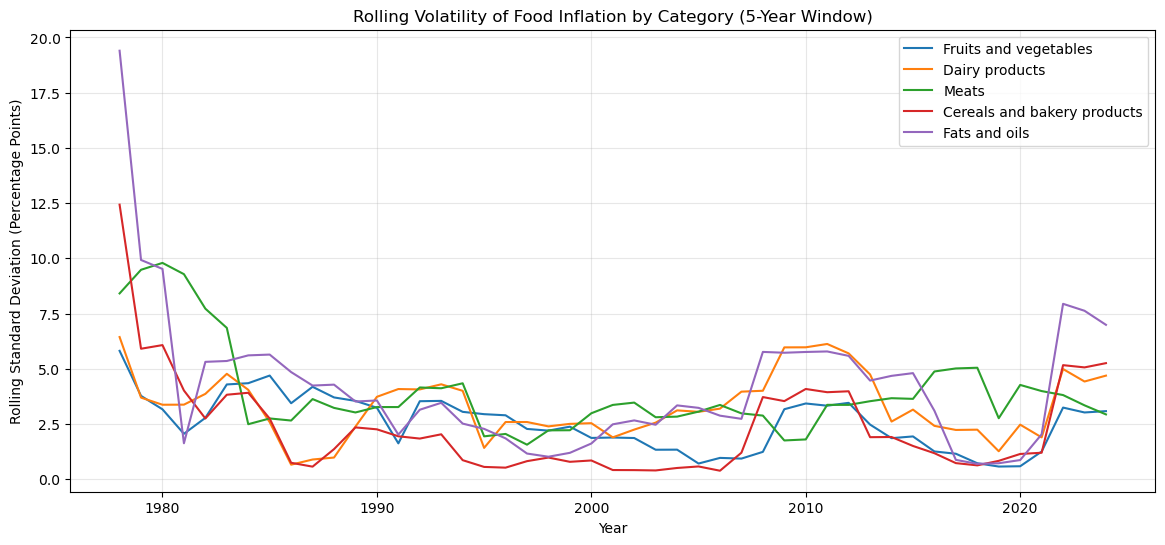

In [32]:
plt.figure()

for category in food_categories:
    plt.plot(
        rolling_volatility.index,
        rolling_volatility[category],
        label=category.replace("_", " ")
    )

plt.title("Rolling Volatility of Food Inflation by Category (5-Year Window)")
plt.xlabel("Year")
plt.ylabel("Rolling Standard Deviation (Percentage Points)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../figures/5y_rolling_volatility_food_inflation_by_category.png")
plt.show()

**Average Volatility**

We can condenses the rolling volatility series into a single summary statistic for each category, capturing how unstable prices tend to be over time. While time-series plots show when volatility spikes occur, average volatility allows us to:
* Rank food categories by overall instability
* Identify which categories contribute most to aggregate food inflation risk
* Compare volatility exposure across food types in a simple, interpretable way

Categories with higher average volatility are more exposed to large and persistent price swings, making them key drivers of food inflation risk. In contrast categories with lower average volatility exhibit more stable pricing patterns over time.

In [33]:
avg_volatility = rolling_volatility.mean().sort_values(ascending=False)
avg_volatility

Fats_and_oils                  4.179148
Meats                          3.903677
Dairy_products                 3.325444
Fruits_and_vegetables          2.558971
Cereals_and_bakery_products    2.338602
dtype: float64

**Volatility Magnitude vs. Volatility Timing by Food Category**

Each point represents a food category, positioned by its average inflation volatility (mean 5-year rolling standard deviation) on the horizontal axis and the average correlation of its volatility with other categories on the vertical axis. Dashed reference lines divide the figure into four quadrants (start from top right moving counter-clockwise):

* (i) high volatility–high synchronization → categories exposed to broad, system-wide shocks
* (ii) high volatility–low synchronization → category-specific instability
* (iii) low volatility–high synchronization → capturing stable prices that move with aggregate conditions
* (iv) low volatility–low synchronization → indicating relatively insulated and stable categories

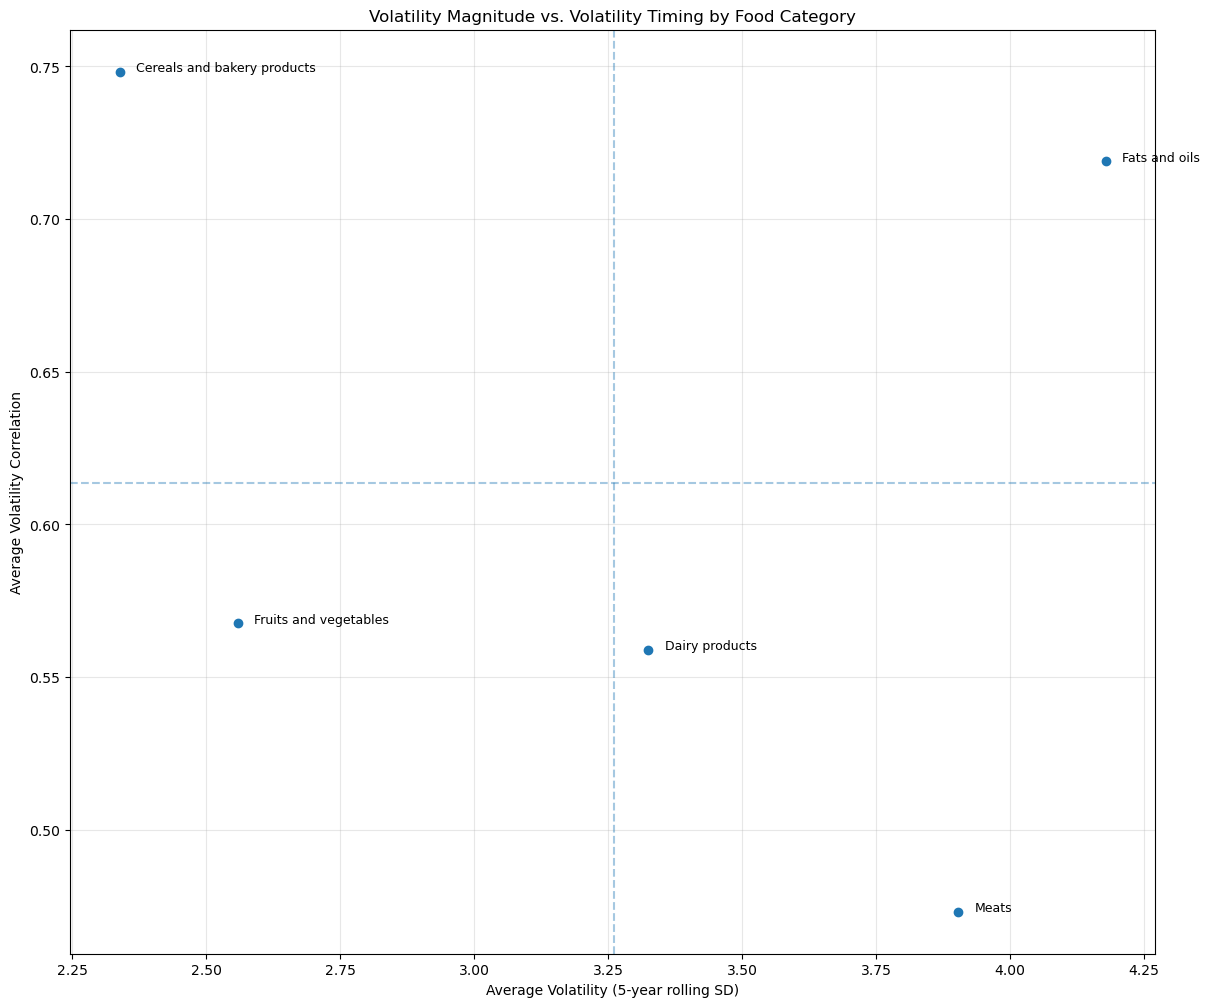

In [34]:
avg_vol = rolling_volatility.mean()
avg_corr = rolling_volatility.corr().mean()

summary = pd.DataFrame({
    "avg_volatility": avg_vol,
    "avg_correlation": avg_corr
})


plt.figure(figsize=(14, 12))
plt.scatter(summary["avg_volatility"], summary["avg_correlation"])

for cat in summary.index:
    plt.text(
        summary.loc[cat, "avg_volatility"] + 0.03,
        summary.loc[cat, "avg_correlation"],
        cat.replace("_", " "),
        fontsize=9
    )

plt.xlabel("Average Volatility (5-year rolling SD)")
plt.ylabel("Average Volatility Correlation")
plt.title("Volatility Magnitude vs. Volatility Timing by Food Category")
plt.grid(alpha=0.3)
plt.axvline(summary["avg_volatility"].mean(), linestyle="--", alpha=0.4)
plt.axhline(summary["avg_correlation"].mean(), linestyle="--", alpha=0.4)
plt.savefig("../figures/volatility_magnitude_vs_volatility_timing_by_food_category.png")
plt.show()

**Volatility Timing** 

Using rolling volatility estimates, we examine whether different food categories experience heightened volatility at the same time or at different points in the sample. Rather than focusing on overall volatility levels, this analysis emphasizes the timing of volatility spikes across categories, allowing us to assess whether inflation uncertainty is synchronized or category-specific.

**Correlation of Volatility Timing**

Each entry reports the correlation between 5-year rolling standard deviations, measuring whether volatility in different food categories tends to rise and fall at the same time. Higher correlations indicate synchronized volatility driven by common shocks, while lower correlations suggest category-specific volatility dynamics.

* High Correlation → 0.6 - 0.7 = Volatility rises and falls together + likely due to common macro or supply-chain shocks 
* Low Correlation → 0.15 - 0.3 = Volatility is category specific + like due to sectoral factors (weather, disease, etc.)

In [35]:
volatility_timing_corr = rolling_volatility.corr()
volatility_timing_corr

,Fruits_and_vegetables,Dairy_products,Meats,Cereals_and_bakery_products,Fats_and_oils
Fruits_and_vegetables,1.000000,0.373278,0.196787,0.610481,0.658216
Dairy_products,0.373278,1.000000,0.175389,0.682365,0.563742
Meats,0.196787,0.175389,1.000000,0.534547,0.459167
Cereals_and_bakery_products,0.610481,0.682365,0.534547,1.000000,0.913985
Fats_and_oils,0.658216,0.563742,0.459167,0.913985,1.000000


**Volatility Spikes**

Periods where volatility spikes simultaneously across categories correspond to higher correlations in rolling volatility, indicating broad inflationary shocks. In contrast, isolated volatility episodes (visible when only one category diverges) are consistent with lower correlation and category-specific supply disturbances.

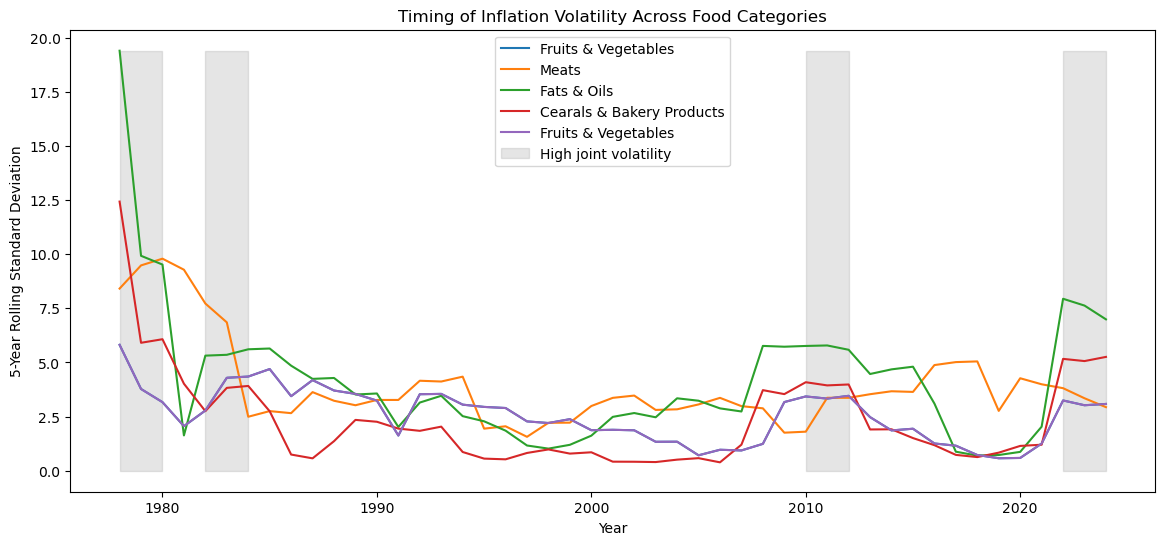

In [36]:
# 1. Average volatility across categories
avg_volatility_ts = rolling_volatility.mean(axis=1)

# 2. Define "high volatility" as top 25%
threshold = avg_volatility_ts.quantile(0.75)
high_vol_periods = avg_volatility_ts > threshold

# 3. Plot volatility timing
plt.figure()
plt.plot(rolling_volatility.index, rolling_volatility["Fruits_and_vegetables"], label="Fruits & Vegetables")
plt.plot(rolling_volatility.index, rolling_volatility["Meats"], label="Meats")
plt.plot(rolling_volatility.index, rolling_volatility["Fats_and_oils"], label="Fats & Oils")
plt.plot(rolling_volatility.index, rolling_volatility["Cereals_and_bakery_products"], label="Cearals & Bakery Products")
plt.plot(rolling_volatility.index, rolling_volatility["Fruits_and_vegetables"], label="Fruits & Vegetables")

# 4. Shade high-volatility periods
plt.fill_between(
    rolling_volatility.index,
    0,
    rolling_volatility.max().max(),
    where=high_vol_periods,
    color="gray",
    alpha=0.2,
    label="High joint volatility"
)

plt.title("Timing of Inflation Volatility Across Food Categories")
plt.ylabel("5-Year Rolling Standard Deviation")
plt.xlabel("Year")
plt.legend()
plt.savefig("../figures/timing_of_inflation_volatility_across_food_categories.png")
plt.show()

## Persistance

**Autocorrelation of Food Inflation by Category**

Taken together with the volatility analysis, persistence helps distinguish categories that are not only volatile, but also slow to adjust once prices change. Categories with higher persistence experience inflation shocks that linger over time, whereas categories with lower persistence tend to revert more quickly after price changes.

In [37]:
# Lag-1 autocorrelation (persistence) by food category
category_persistence = pd.Series(
    {
        category: cpi[category].autocorr(lag=1)
        for category in food_categories
    }
).sort_values(ascending=False)

category_persistence

Cereals_and_bakery_products    0.497795
Fruits_and_vegetables          0.325577
Meats                          0.216210
Fats_and_oils                  0.165405
Dairy_products                 0.130834
dtype: float64

## Co-movement and Correlation Across Food Categories

This figure presents a correlation matrix of annual inflation rates across major food categories. Each cell reports the pairwise correlation between category-specific inflation series, summarizing the extent to which different food prices move together over time.


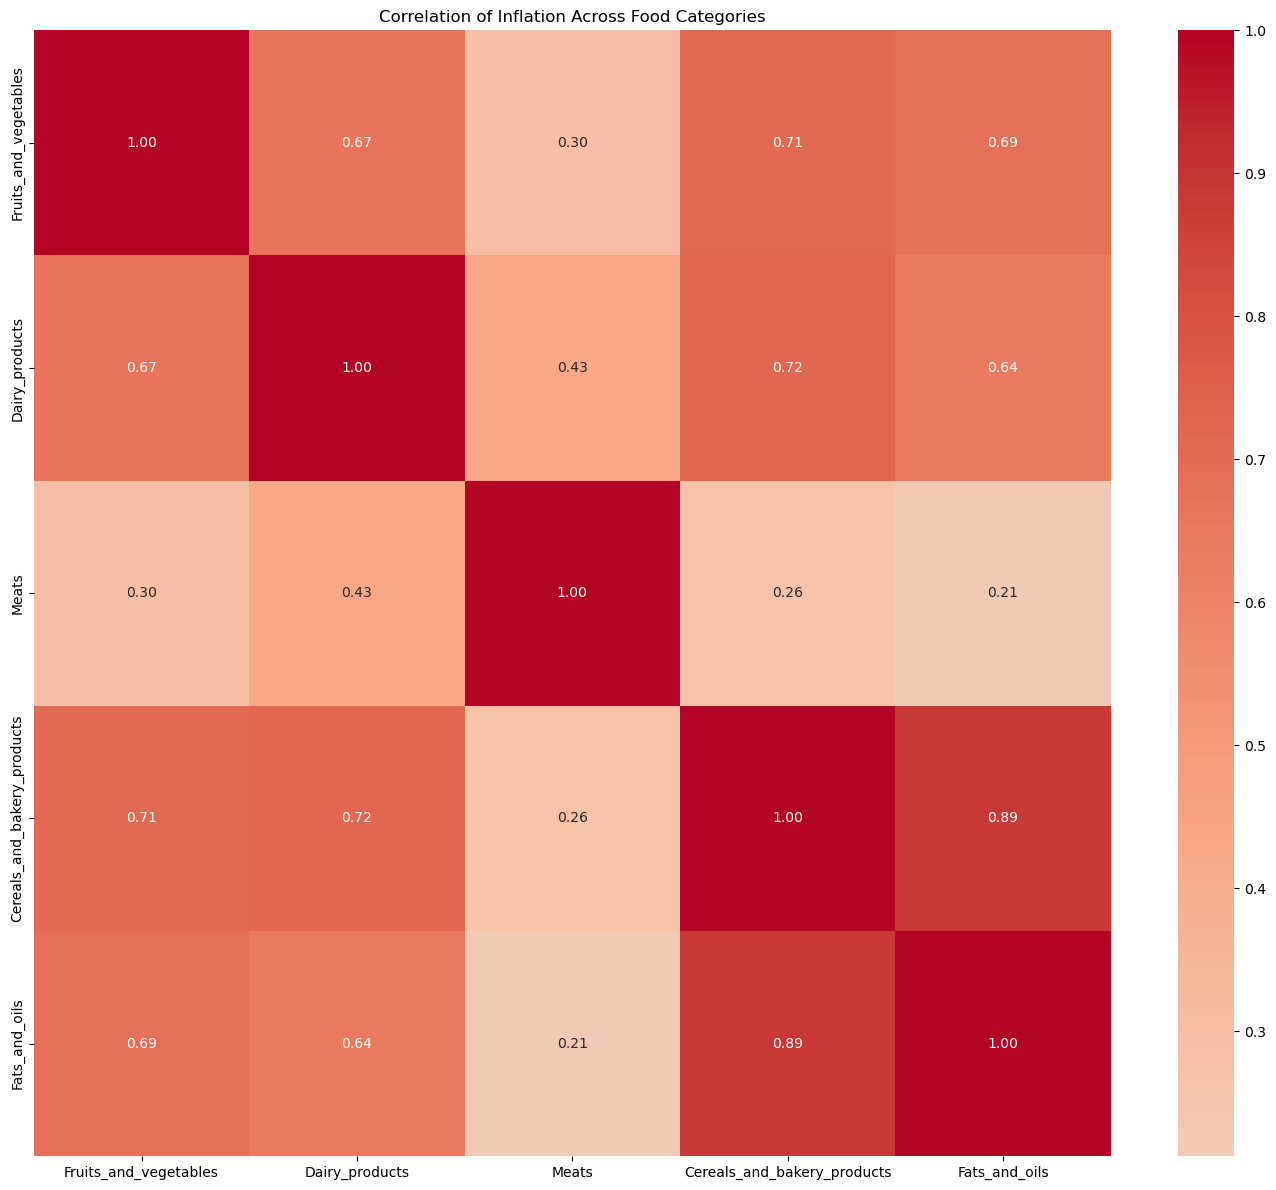

In [38]:
# Correlation matrix across food categories
corr_matrix = cpi[food_categories].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)

plt.title("Correlation of Inflation Across Food Categories")
plt.tight_layout()
plt.savefig("../figures/corr_of_inflation_across_food_categories.png")
plt.show()

## Further Reading and Code References

For additional background on time-series concepts such as rolling windows, volatility measures, and structural change, see:

- STAT 153 Lecture 9: *Time Series and Change Point Methods*  
  https://stat153.berkeley.edu/spring-2025/codelecturenine153248spring2025

For practical Python implementations and examples of time-series analysis, including rolling statistics and visualization, see:

- Prashant Banerjee, *Complete Guide on Time Series Analysis in Python* (Kaggle)  
  https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
